In [44]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
stop_words = set(stopwords.words('english'))

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/Users/kirillkonca/Documents/dementia_prediction/data.csv")

tasks = {
    "MCI vs. AD": df[df['diagnosis'].isin(['MCI', 'AD'])],
    "MCI vs. Control": df[df['diagnosis'].isin(['MCI', 'Control'])],
    "MCI vs. AD vs. Control": df
}

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "SVM": SVC(kernel="sigmoid", random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

f1_scorer = make_scorer(f1_score, average="macro")

results = []

for task_name, task_df in tasks.items():
    print(f"\n### {task_name} ###\n")
    X = task_df['speech']
    y = LabelEncoder().fit_transform(task_df['diagnosis'])

    for model_name, model in models.items():
        print(f"\nModel: {model_name}")
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=5000, stop_words=stop_words)),
            ('clf', model)
        ])

        scores = cross_val_score(pipeline, X, y, cv=kf, scoring=f1_scorer)

        print(f"F1-Macro: {scores.mean():.4f} ± {scores.std():.4f}")

        results.append({
            "Task": task_name,
            "Model": model_name,
            "Mean F1 Macro": scores.mean(),
            "Std F1": scores.std(),
        }
        )


### MCI vs. AD ###


Model: Random Forest
F1-Macro: 0.4614 ± 0.0178

Model: SVM
F1-Macro: 0.6763 ± 0.0769

Model: Logistic Regression
F1-Macro: 0.6734 ± 0.1016

### MCI vs. Control ###


Model: Random Forest
F1-Macro: 0.4588 ± 0.0148

Model: SVM
F1-Macro: 0.5398 ± 0.1314

Model: Logistic Regression
F1-Macro: 0.5198 ± 0.1007

### MCI vs. AD vs. Control ###


Model: Random Forest
F1-Macro: 0.5141 ± 0.0294

Model: SVM
F1-Macro: 0.5606 ± 0.0502

Model: Logistic Regression
F1-Macro: 0.5658 ± 0.0665


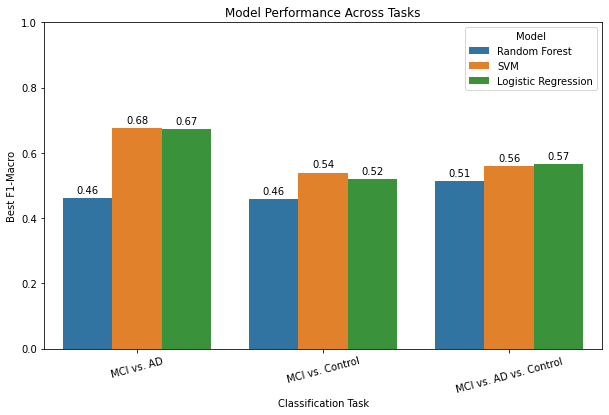

In [51]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=results_df,
    x="Task",
    y="Mean F1 Macro",
    hue="Model",
    capsize=0.1,
    errwidth=1.5
)

plt.ylim(0, 1)
plt.ylabel("Best F1-Macro")
plt.xlabel("Classification Task")
plt.title("Model Performance Across Tasks")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Add labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

plt.show()

In [133]:
import pandas as pd
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key): self.key = key
    def fit(self, X, y=None): return self
    def transform(self, X): return X[self.key].values  # Convert to 1D array

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys): self.keys = keys
    def fit(self, X, y=None): return self
    def transform(self, X): return X[self.keys]  # Keep multiple numerical columns as DataFrame

df = pd.read_csv("/Users/kirillkonca/Documents/dementia_prediction/data.csv")

X = df[['speech'] + numerical_features]  # Speech (text) + Multiple numerical features
y = LabelEncoder().fit_transform(df['diagnosis'])  # Encode labels

feature_union = FeatureUnion([
    ('text_features', Pipeline([
        ('selector', TextSelector('speech')), 
        ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=5000))
    ])),
    ('numerical_features', Pipeline([
        ('selector', NumberSelector(numerical_features)), 
        ('scaler', StandardScaler())  # Scale all numerical features together
    ]))
])

svm_model = SVC(kernel="sigmoid", random_state=42, class_weight='balanced')

pipeline = Pipeline([
    ('features', feature_union),  # Process text and numerical features separately
    ('clf', svm_model)  # Classification model
])

param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'],
    'clf__gamma': ['scale', 'auto']
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best F1-macro score:", grid_search.best_score_)


Best parameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Best F1-macro score: 0.5490487900289432
